In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("starblasters8/human-vs-llm-text-corpus")

print("Path to dataset files:", path)

100%|██████████| 1.92G/1.92G [00:50<00:00, 40.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/starblasters8/human-vs-llm-text-corpus/versions/2


In [ ]:
import os
import shutil

os.makedirs("/root/.kaggle", exist_ok=True)

shutil.copy("/content/kaggle (1).json", "/root/.kaggle/kaggle.json")

# Set correct permissions
os.chmod("/root/.kaggle/kaggle.json", 0o600)

# Now download the dataset from Kaggle
!kaggle datasets download -d starblasters8/human-vs-llm-text-corpus --unzip

# Verify the files
print("Downloaded files:", os.listdir())

Dataset URL: https://www.kaggle.com/datasets/starblasters8/human-vs-llm-text-corpus
License(s): MIT
Downloaded files: ['.config', 'prompts.parquet', 'kaggle (1).json', 'data.parquet', 'prompts.csv', 'distribution.parquet', 'data.csv', 'distribution.csv', 'sample_data']


In [ ]:
import pandas as pd

# Load the CSV file from Google Drive
df = pd.read_csv('/content/drive/MyDrive/Data/data (1).csv')
df.head()

,text,source,prompt_id,text_length,word_count
0,"Federal law supersedes state law, and cannabis...",Bloom-7B,0,967,157
1,Miles feels restless after working all day. He...,Bloom-7B,0,5068,778
2,So first of I am danish. That means that I fol...,Bloom-7B,0,1602,267
3,In this paper we present a novel rule-based ap...,Bloom-7B,0,5469,848
4,"Most social progressives, love democracy, and ...",Bloom-7B,0,2379,380


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788922 entries, 0 to 788921
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         788922 non-null  object
 1   source       788922 non-null  object
 2   prompt_id    788922 non-null  int64 
 3   text_length  788922 non-null  int64 
 4   word_count   788922 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 30.1+ MB


In [ ]:
# Display all column names
print("Dataset Columns:", df.columns)

Dataset Columns: Index(['text', 'source', 'prompt_id', 'text_length', 'word_count'], dtype='object')


In [ ]:
df['source'].value_counts()

,count
source,
Human,347692
GPT-3.5,52346
Text-Davinci-003,22860
Text-Davinci-002,21436
OPT-1.3B,18467
...,...
Toppy-M-7B,433
LLaMA-2-7B,409
Dolphin-Mixtral-8x7B,407


In [ ]:
df.rename(columns={'source': 'label'}, inplace=True)

In [ ]:
# Check for missing values
print(df.isnull().sum())

# Show basic statistics
print(df.describe())

text           0
label          0
prompt_id      0
text_length    0
word_count     0
dtype: int64
           prompt_id    text_length     word_count
count  788922.000000  788922.000000  788922.000000
mean      420.069514    3123.374844     497.983404
std      1381.285340    4963.074433     720.866585
min         0.000000     105.000000      25.000000
25%         0.000000     647.000000     110.000000
50%         0.000000    1921.000000     324.000000
75%         0.000000    3910.000000     624.000000
max      9913.000000  890119.000000   71543.000000


In [ ]:
df.rename(columns={'source': 'label'}, inplace=True)

# Balance the sample: 1,000 human + 1,000 LLM examples
df_human = df[df['label'].str.lower() == 'human'].sample(n=1000, random_state=42)
df_llm = df[df['label'].str.lower() != 'human'].sample(n=1000, random_state=42)

# Combine and shuffle
subset_df = pd.concat([df_human, df_llm]).sample(frac=1, random_state=42).reset_index(drop=True)

# Optional: Save subset for reuse
subset_df.to_csv('/content/drive/MyDrive/llm_human_subset.csv', index=False)

# Check balance
subset_df['label'].value_counts()

,count
label,
Human,1000
GPT-3.5,107
Text-Davinci-002,53
Text-Davinci-003,38
OPT-1.3B,37
...,...
Nous-Hermes-LLaMA-2-70B,1
Gemini-Pro,1
Goliath-120B,1


In [ ]:
subset_df.head()

,text,label,prompt_id,text_length,word_count
0,Lily wanted to make a garland for her dad's bi...,OPT-1.3B,0,376,70
1,Global Business Environment Essay\n\nTable of ...,Human,0,20229,3212
2,The rock legends' set went out on the BBC Worl...,OPT-350M,0,882,151
3,Violence Against Women in the TV Shows Essay\n...,Human,0,24772,4170
4,The purpose of this study is to investigate th...,Psyfighter-2-13B,4889,3333,529


In [ ]:
# Load your balanced subset
df = pd.read_csv('/content/drive/MyDrive/llm_human_subset.csv')
df.rename(columns={'source': 'label'}, inplace=True)  # in case not already renamed

# Create binary label: 1 for human, 0 for LLM
df['binary_label'] = df['label'].apply(lambda x: 1 if x.lower() == 'human' else 0)

In [ ]:
# Step 0: Install spaCy and English language model
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
def extract_features(text):
    doc = nlp(text)
    words = [token.text for token in doc if token.is_alpha]
    word_count = len(words)
    sentence_count = len(list(doc.sents))
    unique_words = len(set(words))
    char_count = sum(len(word) for word in words)

    return pd.Series({
        'avg_word_length': char_count / word_count if word_count else 0,
        'lexical_diversity': unique_words / word_count if word_count else 0,
        'avg_sentence_length': word_count / sentence_count if sentence_count else 0
    })

# Apply to all rows
feature_df = df['text'].apply(extract_features)

# Add original columns for modeling
feature_df['text_length'] = df['text_length'] if 'text_length' in df.columns else df['text'].apply(len)
feature_df['word_count'] = df['word_count'] if 'word_count' in df.columns else df['text'].apply(lambda x: len(x.split()))
feature_df['label'] = df['binary_label']

from tqdm import tqdm
tqdm.pandas()
feature_df = df['text'].progress_apply(extract_features)

100%|██████████| 2000/2000 [03:42<00:00,  8.97it/s]


In [ ]:
# This adds the correct label column for modeling
feature_df['label'] = df['binary_label']

In [ ]:
from sklearn.model_selection import train_test_split

X = feature_df.drop(columns=['label'])  # only feature columns
y = feature_df['label']                 # target labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.68      0.69       203
           1       0.68      0.71      0.70       197

    accuracy                           0.69       400
   macro avg       0.70      0.70      0.69       400
weighted avg       0.70      0.69      0.69       400

Confusion Matrix:
 [[138  65]
 [ 57 140]]


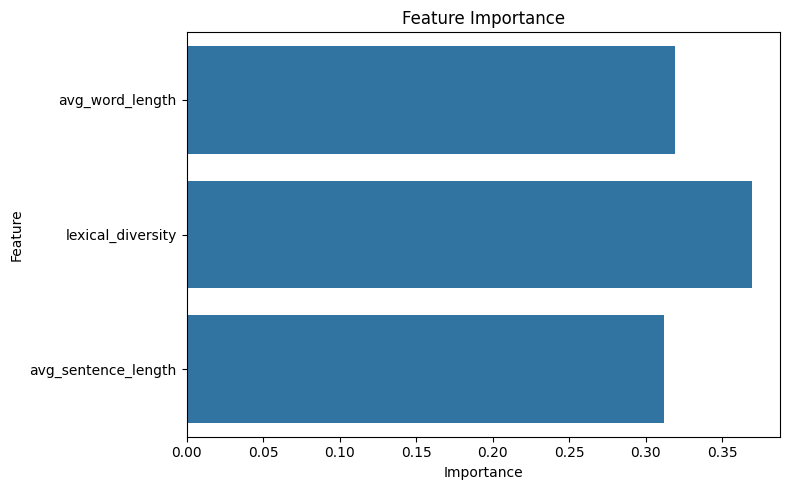

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot importance
importance = model.feature_importances_
features = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importance, y=features)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
# Instead of sampling 100 rows
sample_df = df.copy()  # Use all 1000 rows from your subset
sample_df['true_label'] = sample_df['binary_label']

# Simulate human annotations (80% accurate)
np.random.seed(42)
sample_df['human_judgment'] = sample_df['true_label'].apply(
    lambda x: x if np.random.rand() < 0.8 else 1 - x
)

# Step 1: Simulate features using your function
sample_features = sample_df['text'].apply(extract_features)

# Step 2: Add the original columns before prediction (IN the same DataFrame)
sample_features['text_length'] = sample_df['text'].apply(len)
sample_features['word_count'] = sample_df['text'].apply(lambda x: len(x.split()))

# Reorder to match training feature order
sample_features = sample_features[X.columns]  # X from earlier train-test split

# Step 3: Predict using trained model
sample_df['model_prediction'] = model.predict(sample_features)
# Evaluation
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

print("Accuracy - Human vs. True:", accuracy_score(sample_df['true_label'], sample_df['human_judgment']))
print("Accuracy - Model vs. True:", accuracy_score(sample_df['true_label'], sample_df['model_prediction']))
print("Agreement - Human vs. Model (Cohen's Kappa):", cohen_kappa_score(sample_df['human_judgment'], sample_df['model_prediction']))
print("Confusion Matrix - Human vs. Model:")
print(confusion_matrix(sample_df['human_judgment'], sample_df['model_prediction']))

Accuracy - Human vs. True: 0.7985
Accuracy - Model vs. True: 0.939
Agreement - Human vs. Model (Cohen's Kappa): 0.5349144242540628
Confusion Matrix - Human vs. Model:
[[752 225]
 [240 783]]


In [ ]:
# Step 1: Filter disagreements
disagreements = sample_df[sample_df['human_judgment'] != sample_df['model_prediction']]

# Step 2: Sample a few to inspect
example_rows = disagreements.sample(n=5, random_state=42)

# Step 3: Display key info
for idx, row in example_rows.iterrows():
    print(f"\n🔹 Example {idx}")
    print(f"True Label: {'Human' if row['true_label'] == 1 else 'LLM'}")
    print(f"Human Annotator Guess: {'Human' if row['human_judgment'] == 1 else 'LLM'}")
    print(f"Model Prediction: {'Human' if row['model_prediction'] == 1 else 'LLM'}")
    print("Text Preview:")
    print(row['text'][:500] + '...')  # print first 500 characters only


🔹 Example 228
True Label: LLM
Human Annotator Guess: Human
Model Prediction: LLM
Text Preview:
Simply rub yogurt onto your skin, leave it on for a few minutes, then rinse it off with lukewarm water. To notice a change in your skin's complexion apply this to the morning after you cleanse and tone followed by an evening application before bedtime. 7) Coconut oil: It is more stable than other oils that can be used as moisturizer. The scent of coconut has been shown to improve moods which could help make you feel better about yourself. 8) Aloe vera gel: When applied topically on acne-prone ar...

🔹 Example 280
True Label: LLM
Human Annotator Guess: Human
Model Prediction: LLM
Text Preview:
Having a positive attitude is a crucial aspect of life that can greatly impact our success and happiness. It is a mindset that allows us to approach challenges with optimism, resilience, and determination. In this essay, I will explore the reasons why having a positive attitude is the key to success in 

In [ ]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.9 MB/s eta 0:00:00


In [ ]:
import textstat
from textblob import TextBlob
import re

def analyze_text_features(text):
    # Readability score
    readability = textstat.flesch_reading_ease(text)

    # Sentiment polarity
    sentiment = TextBlob(text).sentiment.polarity

    # Lexical diversity (using simple .split() to avoid NLTK)
    words = text.split()
    lexical_diversity = len(set(words)) / len(words) if words else 0

    # Pronoun count
    pronouns = re.findall(r'\b(I|we|you|he|she|they|me|us|him|her|them)\b', text, flags=re.IGNORECASE)
    pronoun_count = len(pronouns)

    return {
        'readability': readability,
        'sentiment': sentiment,
        'lexical_diversity': lexical_diversity,
        'pronoun_count': pronoun_count
    }

In [ ]:
# Clean and ensure text is string
disagreements['text'] = disagreements['text'].astype(str)

# Analyze features
disagreement_features = disagreements['text'].apply(analyze_text_features)

# Combine
disagreement_analysis = pd.concat([disagreements.reset_index(drop=True), disagreement_features.apply(pd.Series)], axis=1)

# Display sample with error-proof preview
for idx, row in disagreement_analysis.sample(n=5, random_state=42).iterrows():
    text_preview = str(row['text'])[:500] + '...' if pd.notnull(row['text']) else "[Missing Text]"

    print(f"\n🔍 Example {idx}")
    print(f"True Label: {'Human' if row['true_label'] == 1 else 'LLM'}")
    print(f"Human Annotator Guess: {'Human' if row['human_judgment'] == 1 else 'LLM'}")
    print(f"Model Prediction: {'Human' if row['model_prediction'] == 1 else 'LLM'}")
    print("Text Preview:")
    print(text_preview)
    print(f"\n🧠 Readability Score: {row['readability']}")
    print(f"💬 Sentiment Polarity: {row['sentiment']:.2f}")
    print(f"🧍 Pronouns Used: {row['pronoun_count']}")
    print(f"🧠 Lexical Diversity: {row['lexical_diversity']:.2f}")

<ipython-input-22-8dbf5b72a618>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disagreements['text'] = disagreements['text'].astype(str)



🔍 Example 196
True Label: Human
Human Annotator Guess: Human
Model Prediction: LLM
Text Preview:
Eagles? Never once heard of an eagle attacking someone, much less killing them. Bear, moose, and cougar attacks (not to mention wolves, coyotes, and alligators!) are also very rare, mostly because those animals generally live far away from humans and rarely encounter them. Australia, on the other hand, has a lot of dangerous animals that live comparatively close to humans, namely venomous spiders, snakes, and jellyfish. That said, I've been unable to dig up any actual statistics on animal-relate...

🧠 Readability Score: 72.8
💬 Sentiment Polarity: -0.13
🧍 Pronouns Used: 124.0
🧠 Lexical Diversity: 0.08

🔍 Example 299
True Label: LLM
Human Annotator Guess: Human
Model Prediction: LLM
Text Preview:
 Public art, an amalgamation of creativity and cultural expression, permeates the urban landscapes of our cities. It serves as a palimpsest, bearing the imprints of history, society, and the human c

In [ ]:
# Drop rows where any feature is NaN
feature_cols = ['readability', 'sentiment', 'pronoun_count', 'lexical_diversity']
disagreement_clean = disagreement_analysis.dropna(subset=feature_cols).copy()

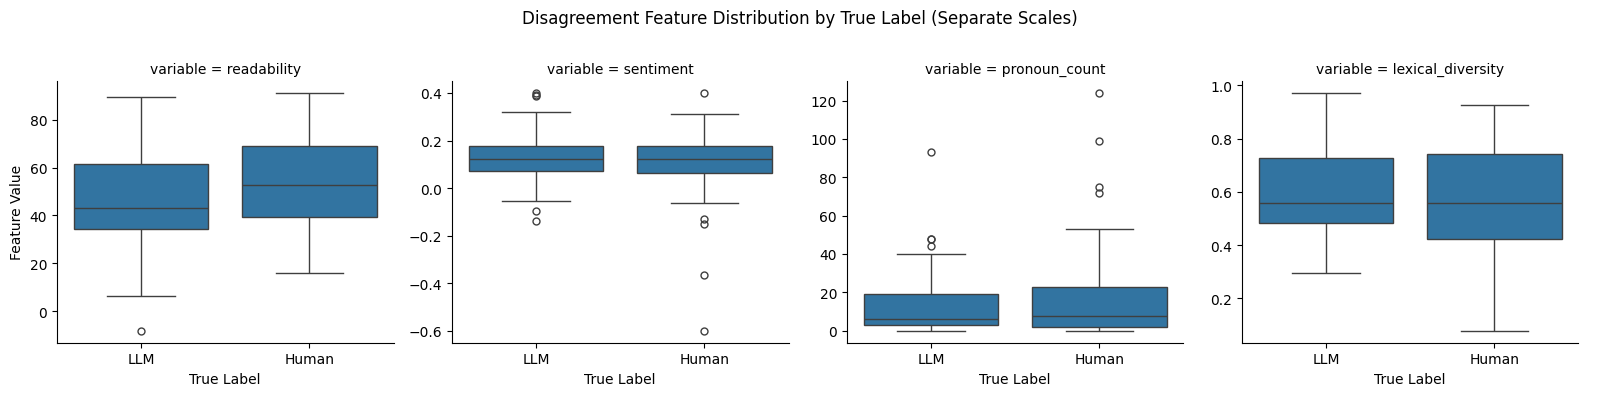

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melted dataframe already prepared
melted = disagreement_clean.melt(id_vars='true_label', value_vars=feature_cols)
melted['true_label'] = melted['true_label'].map({0: 'LLM', 1: 'Human'})

# Plot with separate scales
g = sns.catplot(
    data=melted, x='true_label', y='value', col='variable',
    kind='box', sharey=False, height=4, aspect=1
)

g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Disagreement Feature Distribution by True Label (Separate Scales)")
g.set_axis_labels("True Label", "Feature Value")
plt.show()

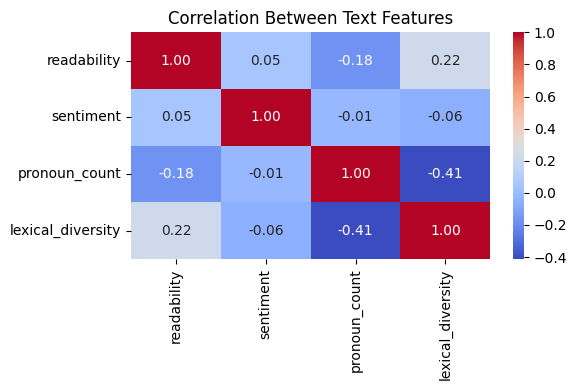

In [ ]:
# Compute correlation
corr = disagreement_clean[feature_cols].corr()

# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Text Features")
plt.tight_layout()
plt.show()

In [ ]:
nlp.enable_pipe("senter")  # Optional safety, depending on spaCy version

In [ ]:
def has_nonstandard_grammar(text):
    doc = nlp(text)
    frag_count = sum(
        1 for sent in doc.sents
        if not any(tok.dep_ == 'nsubj' for tok in sent) or not any(tok.pos_ == 'VERB' for tok in sent)
    )
    return frag_count > 0

In [ ]:
contradiction_patterns = [
    r"\bbut\b.*?\bhowever\b",
    r"\byet\b.*?\balso\b",
    r"\bon the other hand\b",
    r"\bdespite\b.*?\bstill\b"
]

In [ ]:
!pip install transformers --quiet
from transformers import pipeline

In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
df['sentiment'] = df['text'].apply(lambda x: sentiment_pipeline(x[:512])[0]['label'])  # Truncate long text

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

# Load spaCy
nlp = spacy.load("en_core_web_sm")

# Define heuristics
def has_nonstandard_grammar(text):
    doc = nlp(text)
    frag_count = sum(1 for sent in doc.sents if len(sent) < 5 or not any(tok.dep_ == 'nsubj' for tok in sent))
    return frag_count >= 1

def has_ironic_or_cultural_cue(text):
    cues = ["as if", "yeah right", "because of course", "totally", "sarcasm", "obviously", "great job", "classic"]
    return any(cue in text.lower() for cue in cues)

def has_logical_inconsistency(text):
    contradiction_patterns = [r"\bbut\b.*\bhowever\b", r"\byet\b.*\balso\b", r"\bon the other hand\b"]
    return any(re.search(pattern, text.lower()) for pattern in contradiction_patterns)

# Apply to DataFrame `df` (replace if your disagreement set is named differently)
df['nonstandard_grammar'] = df['text'].apply(has_nonstandard_grammar)
df['irony_or_culture'] = df['text'].apply(has_ironic_or_cultural_cue)
df['logical_inconsistency'] = df['text'].apply(has_logical_inconsistency)

# Tag dominant reason
def tag_reason(row):
    reasons = []
    if row['irony_or_culture']:
        reasons.append("Humor/Irony/Culture")
    if row['nonstandard_grammar']:
        reasons.append("Nonstandard Grammar")
    if row['logical_inconsistency']:
        reasons.append("Logical Inconsistency")
    return ", ".join(reasons) if reasons else "Unclear"

df['failure_reason'] = df.apply(tag_reason, axis=1)

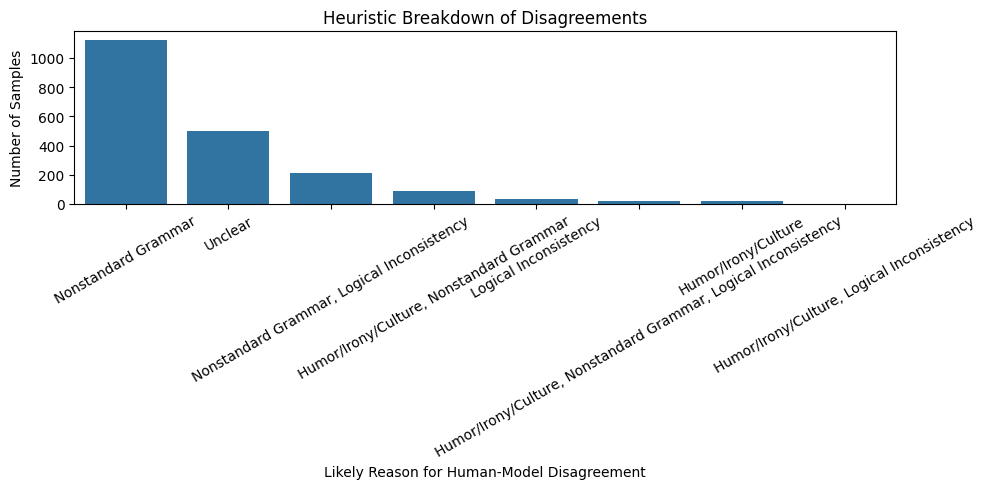

In [ ]:

# ✅ Visualization: Count Plot of Failure Reasons
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='failure_reason', order=df['failure_reason'].value_counts().index)
plt.title("Heuristic Breakdown of Disagreements")
plt.xlabel("Likely Reason for Human-Model Disagreement")
plt.ylabel("Number of Samples")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()